# Creating and Visualizing a Scene with Geo2SigMap

The [Geo2SigMap](https://github.com/functions-lab/geo2sigmap) package is a powerful new package developed by [Tingjun Chen's lab](https://functions-lab.github.io/) at Duke University that enables users to generate 3D models for arbitary geographic regions.  These 3D models can be directly used by Sionna.  In this demo, you will learn to:

* Use [Geo2SigMap](https://github.com/functions-lab/geo2sigmap) to create a 3D model of an area of interest
* Save meta data of the area
* Plot the area and highlight points with given lat-long coordiantes.

Thanks to the amazing PhD student, Mingyun Ying, for helping with coordinate transformations.


## Creating the 3D Model

A [readme file](./readme.md) shows how to create the 3D model with the `scenegen` package. 


Basically, the steps are:

* Follow the instructions on [Geo2SigMap](https://github.com/functions-lab/geo2sigmap) to install `geo2sigmap`.
* Go to the [bounding finder website](https://bboxfinder.com/).  There are several sites that provide this service as well.
* Zoom into the area of interest.  In this case, I selected a small area around the NYU Tandon campus.  (See the figure below).
* Select the area and read the bounding box coordinates from the lower left bar
* Run a command to similar to the following to the build 3D model:
```bash
	scenegen bbox -73.990291 40.691239 -73.981869 40.696608 --data-dir nyu_tandon
```
The coordinates are lat-long of the upper left and bottom right coordinates and were found from the bounding box website.  This command will create a directory `nyu_tandon` with the 3D model.

<img src="https://github.com/sdrangan/wirelesscomm/blob/master/docs/geodemo/bbox_screenshot.png?raw=true" alt="Description" width=700>






## Saving Map Meta Data

After you have created a scene, it is useful to record the meta data for the scene.  Perhaps, in the future, a file like this could be automatically created by the geo2sigmap.

In [1]:
import os
import pickle

map_data = dict()
map_data['bbox_lat'] = [40.691239, 40.696608]
map_data['bbox_long'] = [-73.990291, -73.981869]
map_data['name'] = 'NYU Tandon'

scene_dir = os.path.join(os.getcwd(), 'nyu_tandon')
file_path = os.path.join(scene_dir, 'map_data.pkl')

# Storing the data using pickle
with open(file_path, 'wb') as file:
    pickle.dump(map_data, file)

We can now load it as follows:

In [2]:
# Loading the data using pickle
with open(file_path, 'rb') as file:
    map_data = pickle.load(file)

## Importing Sionna
We next import sionna and sionnautils package as usual.

In [13]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

We also import the sionnautils package from the wireless class

In [14]:
# Import Sionna utils from the wireless class
try:
    import sionnautils
except ImportError as e:
    # Install Sionna if package is not already installed
    !pip install git+https://github.com/sdrangan/wirelesscomm.git
    import sionnautils

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

## Loading and viewing the scene

You can now import the scene with the standard command.

In [16]:
import os
nyu_tandon_scene = os.path.join(os.getcwd(), 'nyu_tandon\\scene.xml')
print(nyu_tandon_scene)
os.path.exists(nyu_tandon_scene)

scene = sionna.rt.load_scene(nyu_tandon_scene)

C:\Users\sdran\Dropbox\srangan\academic\courses\Wireless\wirelesscomm\docs\geodemo\nyu_tandon\scene.xml


In [17]:
# Render scene
if no_preview:
    scene.render(camera="scene-cam-0", num_samples=512);

In [18]:
%%skip_if no_preview
# Open 3D preview (only works in Jupyter notebook)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Extracting the Buildings

We next use the sionnautils package to extract the buildings.

In [19]:
from sionnautils.miutils import CoverageMapPlanner

grid_size = 5

cm = CoverageMapPlanner(scene._scene, grid_size=grid_size)
cm.set_grid()
cm.compute_grid_attributes()

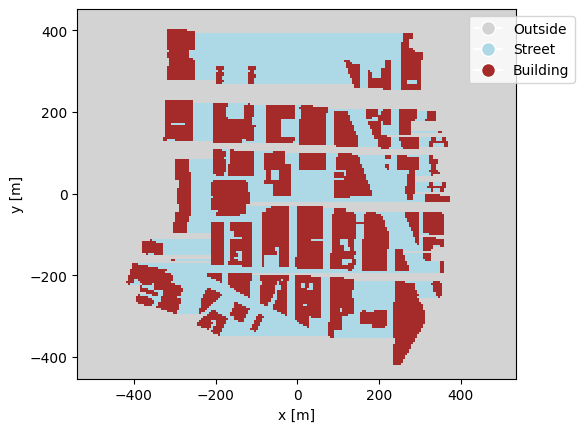

In [20]:
# Define a custom color map with RGB values
from matplotlib.colors import ListedColormap
colors = ['lightgray', 'lightblue', 'brown']
cmap = ListedColormap(colors)


#  Create a grid of point types
outdoor = (cm.bldg_grid==False) & cm.in_region
building = (cm.bldg_grid) & cm.in_region
point_type = outdoor + 2*building
point_type = point_type.astype(int)
point_type = np.flipud(point_type)

# Plot the grid
extent = extent=[cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)

# Create a legend
legend_labels = ['Outside', 'Street', 'Building']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1))

# Add titles and labels
_ = plt.xlabel('x [m]')
_ = plt.ylabel('y [m]')

## Highlight a Street Address with Given Lat-Long Coordinates

Often you have points in (lat, long) coordinates that you want to place in the coverage area.  

First, we can find a location, for example, with the `geopy` package.  You can also directly find the lat-long from Google maps.  In this case, the adderss is one of NYU's engineering buildings (where my office is in case you want to visit).

In [69]:
from geopy.geocoders import Nominatim

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="wireless_class")

# Address to get coordinates for
#address = "5 MetroTech Center, Brooklyn, NY 11201"
address = "370 Jay St, Brooklyn, NY 11201"

# Geocode the address
location = geolocator.geocode(address)

# Print the lat-long
print('lat = %f' % location.latitude)
print('long = %f' % location.longitude)

# Set the lat-long
lat = location.latitude
long  = location.longitude


lat = 40.692785
long = -73.987561


Next, we have to convert the latitude and longitude to an `(x,y)` value offset from the center of the bounding box.  For this purpose, we can use the `pyproj` library. 

In [70]:
from pyproj import Transformer

cen_lat = np.mean(map_data['bbox_lat'])
cen_long = np.mean(map_data['bbox_long'])
local_crs = f"+proj=aeqd +lat_0={cen_lat} +lon_0={cen_long} +datum=WGS84 +units=m"
transformer = Transformer.from_crs("epsg:4326", local_crs, always_xy=True)

xp, yp = transformer.transform(long, lat)

# Print the location in meters from the center of the bounding box
print('(x,y) location = %7.2f, %7.2f' % (xp,yp))

(x,y) location = -125.22, -126.47


We now display the point on the map.  

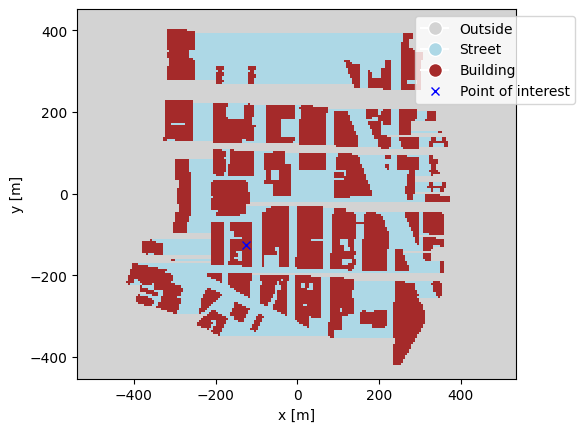

In [71]:
# Plot the grid
extent = extent=[cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)

# PLot the point of interest
h, = plt.plot(xp, yp, 'bx')

# Create a legend for the manually created entries
legend_labels = ['Outside', 'Street', 'Building']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]

# Add the point of interest
handles.append(h)
legend_labels.append('Point of interest')

plt.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1))

# Add titles and labels
_ = plt.xlabel('x [m]')
_ = plt.ylabel('y [m]')
